# Ethoscopy - Behavpy to catch22

#### Catch22 is a shortened version of HCTSA, a time series comparative analysis toolbox in matlab. Catch22 has been adatped to also work in python and uses the top 22 most used analytical tests from the 100s used in HCTSA. 

#### See heere for more details: https://feature-based-time-series-analys.gitbook.io/catch22-features/
#### or their github: https://github.com/DynamicsAndNeuralSystems/pycatch22

## 1. Load the dummy dataset

In [ ]:
import ethoscopy as etho
import pandas as pd
import numpy as np
import pycatch22
# from functools import partial

In [162]:
# Load in the data from the overview tutorial
from ethoscopy.misc.get_tutorials import get_tutorial
data, metadata = get_tutorial('circadian')
df = etho.behavpy(data, metadata, check = True)

## 2. Some data curation

In [166]:
# We'll look at movement here
var = 'moving'

In [ ]:
# The ethoscope if loading with sleep_annoation will interpolate data about sleep, this causes NaN values for the normal variables other than 'asleep'
# So we need to filter it out
df = df[df['is_interpolated'] == False]

In [ ]:
# check to see if any NaN values are left
df[df[var].isnull()]

In [ ]:
# The most basic curation is to pick a specific time period
df = df.t_filter(start_time = 24, end_time = 48)

In [ ]:
# We can also use interpolate to fill in the missing data points, this can be useful if it's only a few points missing per specimen
df = df.interpolate(variable = var, step_size = 60, t_column = 't')

In [ ]:
# We can also group several rows together by increasing the t diff, here we increase
# from 60 to 120, so we find the average of every two rows if there
df = df.bin_time(column = var, bin_secs =  120, function = 'mean')

In [ ]:
# Once we've completed our curation or if we just want to remove specimens that don't have enough values,
# we can call curate to remove all specimens with too few points still
df = df.curate(points = ((24*60*60) / 60)-1) # 24*60*60 = seconds in a day and then divided by are t diff per row. 

# Note: The interpolate method returns rows 1 shorter than before so you'll need to add a minus 1 if using curate after
# Note: If you've called the above bin_time this curate will return an empty dataframe

In [ ]:
# When using x position data the interesting part is how the fly positions itself in relation to the food
# However this will be different on the x,y axis for flies on either side of the ethoscope, so lets normalise it
# You only need to run this is using the x variable
df_r = df.xmv('region_id', list(range(11,21)))
df_l = df.xmv('region_id', list(range(1,11)))
df_r['x'] = 1 - df_r['x']
df = df_l.concat(df_r)

## 3. Normalise the data

#### The ethoscope data can do with a bit of augmentation to make it perform better in HCTSA
#### Try running your data unnormalised and normalised, and with different methods to see the results

In [167]:
# Catch22 takes only lists, but to normalise the data we'll have to put it into a numpy array first
list_x = df.groupby(df.index, sort = False)[var].apply(list)
arr_x = np.array([np.array(x) for x in list_x])
# Here we grab the ids of each for the labels that we'll use later
list_id = list_x.index.tolist()

In [ ]:
# Use some or all of these functions to normalise the data between specimens

# norm transforms the data to be between 0 and 1
def norm(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

# Only use this if looking at phi, it changes it be only from 0-90 or horizontal to veritcal as the ethoscope doesn't track direction
def norm_phi(x):
    return np.where(x > 90, 90 - (x - 90), x)

# Smooth out the time series data
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
# We can have a look at this effect through some plots
import matplotlib.pyplot as plt

In [ ]:
ind1 = np.random.randint(len(arr_x))
ind2 = np.random.randint(len(arr_x))

plt.figure(figsize=(9, 6))
plt.plot(arr_x[ind1], color = 'red')
plt.plot(arr_x[ind2], color = 'blue')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel(f'{var} value', fontsize=12)
plt.show()

In [ ]:
# Apply the function along the axis
arr_x = np.apply_along_axis(norm, 1, arr_x)
arr_x = np.apply_along_axis(partial(moving_average, n = 5), 1, arr_x)

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(arr_x[ind1], color = 'red')
plt.plot(arr_x[ind2], color = 'blue')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel(f'{var} value', fontsize=12)
plt.show()

## 4. Run Catch22 and store in a behavpy dataframe 

In [168]:
# Here the time series data is augmented to fit into the correct format
# it's stored as the variable ts_mat
data = [pycatch22.catch22_all(list_x[i],catch24=True)['values'] for i in range(len(list_x))]
cols = pycatch22.catch22_all(list_x[0],catch24=True)['names']

c22 = pd.DataFrame(data, columns = cols, index = list_id)
c22.index.name = 'id'

c22_df = etho.behavpy(c22, df.meta)

In [ ]:
c22_df.display()

## 5. Classification of results

In [77]:
from sklearn.manifold import TSNE

In [78]:
tsne = TSNE(n_components=2, random_state=0)

In [184]:
c22_df

,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,...,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,DN_Mean,DN_Spread_Std
id,,,,,,,,,,,,,,,,,,,,,
2017-01-16 08:00:00|circadian.txt|01,-0.758695,-0.858780,1.673838,12,0.059970,-0.000618,0.289691,32.0,0.049020,16,...,0.040093,0.506532,2.0,1.293783,0.76,0.70,0.598636,0.940633,0.479029,0.499579
2017-01-16 08:00:00|circadian.txt|02,-0.376782,-0.489851,2.031151,9,0.063545,0.000000,0.219138,20.0,0.052083,12,...,0.033847,0.529316,2.0,1.069585,0.74,0.70,0.522320,0.921140,0.266615,0.442207
2017-01-16 08:00:00|circadian.txt|03,-0.681536,-0.782306,1.644705,11,0.056634,0.000631,0.281055,34.0,0.048454,19,...,-0.013878,0.510139,2.0,1.276403,0.80,0.66,0.597486,0.953303,0.438165,0.496181
2017-01-16 08:00:00|circadian.txt|04,-0.356121,-0.470790,2.525671,12,0.079560,0.000000,0.172720,23.0,0.102751,15,...,0.000463,0.587754,2.0,0.998651,0.78,0.68,0.434884,0.900319,0.255281,0.436036
2017-01-16 08:00:00|circadian.txt|05,-0.190297,-0.322851,3.973674,8,0.072568,-0.001437,0.153057,14.0,0.066667,13,...,0.124672,0.555430,2.0,0.831834,0.44,0.34,0.410723,0.884988,0.171781,0.377205
2017-01-16 08:00:00|circadian.txt|06,-0.439550,-0.548472,0.843715,6,0.028603,0.000000,0.315676,11.0,0.074588,6,...,-0.041943,0.395768,2.0,1.194319,0.74,0.60,0.989418,1.025636,0.301773,0.459045
2017-01-16 08:00:00|circadian.txt|07,-0.187220,-0.320201,0.806490,2,0.006102,0.000000,0.221605,9.0,0.186563,2,...,-0.001465,0.336636,2.0,0.892951,0.88,0.72,1.166592,1.070128,0.170393,0.375992
2017-01-16 08:00:00|circadian.txt|08,-0.431103,-0.540524,2.469564,8,0.073864,-0.000808,0.221837,18.0,0.075680,16,...,0.085042,0.551380,2.0,1.111010,0.78,0.62,0.488189,0.909805,0.296993,0.456951
2017-01-16 08:00:00|circadian.txt|09,-0.651629,-0.752871,1.799252,9,0.062395,0.000000,0.275426,24.0,0.046296,18,...,0.024672,0.519186,2.0,1.264704,0.80,0.70,0.569490,0.935008,0.421820,0.493869


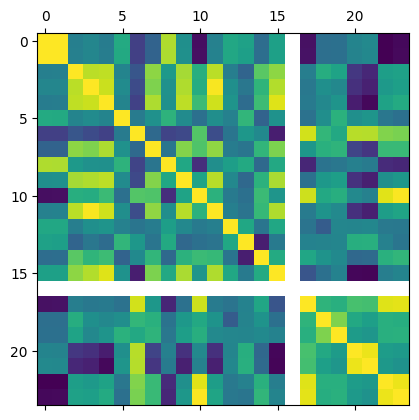

In [183]:
corr_matrix = c22_df.corr()
plt.matshow(corr_matrix)
plt.show()

In [171]:
X = c22_df.values.tolist()
X = np.array([np.array(i) for i in X])

In [170]:
y = np.array(c22_df.meta.period_group.tolist())

In [172]:
X_2d = tsne.fit_transform(X)

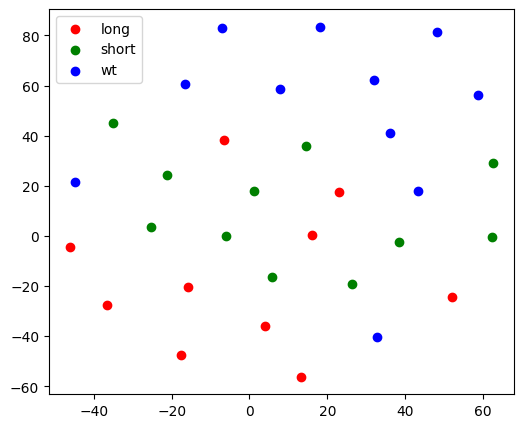

In [174]:
target_ids = set(c22_df.meta.period_group.tolist())

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = ['r', 'g', 'b', 'c']
for i, c, label in zip(target_ids, colors, target_ids):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [156]:
from sklearn import datasets
digits = datasets.load_digits()
# Take the first 500 data points: it's hard to see 1500 points
X = digits.data[:500]
y = digits.target[:10]

In [159]:
y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [157]:
for i in range(len(digits.target_names)):
    print([y == i, 0])
    break

[array([ True, False, False, False, False, False, False, False, False,
       False]), 0]


In [143]:
for i in target_ids:
    print([y == i])

[False]
[False]
[False]
[False]


In [ ]:
for i, c, label in zip(target_ids, colors, target_ids):